In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bike_train = pd.read_csv('./train.csv')
bike_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
bike_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 978.1+ KB


## 变量说明：
#### datatime 日期+时间
#### season 1=春 2=夏 3=秋 4=冬
#### holiday 1=节假日 0=非节假日
#### workingday 1=工作日 0=周末
#### weather 1=晴天多云 2=雾天阴天 3=小雪小雨 4=大雨大雪大雾
#### temp 气温摄氏度
#### atemp 体感温度
#### humidity 湿度
#### windspeed 风速
#### casual 非注册用户个数
#### registered 注册用户个数
#### count 给定日期时间（每小时）总租车人数

### 3.数据清洗
1)数据预处理：数据完整无缺失值
2)特征工程：从datetime中提取年、月、日、时、星期等时间信息

In [4]:
import calendar

bike_train['date'] = bike_train.datetime.apply(lambda x :x.split()[0])
bike_train['year'] = bike_train.date.apply(lambda x:x.split("-")[0])
bike_train['month'] = bike_train.date.apply(lambda x:x.split("-")[1])
bike_train['day'] = bike_train.date.apply(lambda x:x.split("-")[2])
bike_train['hour'] = bike_train.datetime.apply(lambda x: x.split()[1].split(":")[0])
bike_train['weekday'] = bike_train.datetime.apply(lambda x: calendar.day_name[pd.to_datetime(x).weekday()])

In [5]:
#把季节和天气转换成文字
bike_train['season'] = bike_train.season.map({1: "Spring", 2 : "Summer", 
                                              3 : "Fall", 4 :"Winter" })

In [6]:
bike_train[:50:20]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,weekday
0,2011-01-01 00:00:00,Spring,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011-01-01,2011,01,01,00,Saturday
20,2011-01-01 20:00:00,Spring,0,0,2,16.40,20.455,87,16.9979,11,25,36,2011-01-01,2011,01,01,20,Saturday
40,2011-01-02 17:00:00,Spring,0,0,1,13.94,16.665,57,12.9980,7,58,65,2011-01-02,2011,01,02,17,Sunday


#### 可视化分析
1. 单车使用量在天气维度上的分析（天气、温度、湿度、风速相关性）

In [7]:
import seaborn as sns

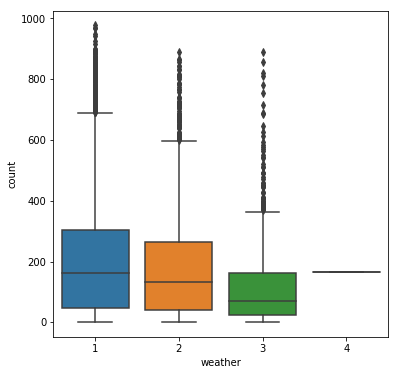

In [9]:
# 租车与天气的关系
fig = plt.subplots(figsize=(6,6))
sns.boxplot(data=bike_train, y = 'count',x = 'weather')

可以看到，整体租车量受天气影响较为明显，极端的天气租车数量减少。
4级天气看起来有些异常，于是统计数据条目：

In [10]:
#统计各天气数据数量
weather_count = pd.DataFrame(bike_train.assign(weather_count=0).groupby('weather').weather_count.apply(len).reset_index())
weather_count['weather']=weather_count.weather.map({1:"晴天、多云",2:"雾天、阴天",3:"小学、小雪",4:"大风、大雪、大雨"})
weather_count

,weather,weather_count
0,晴天、多云,7192
1,雾天、阴天,2834
2,小学、小雪,859
3,大风、大雪、大雨,1


可以看到，4级天气只有1条数据记录，这种极端天气情况出现的数据极少。

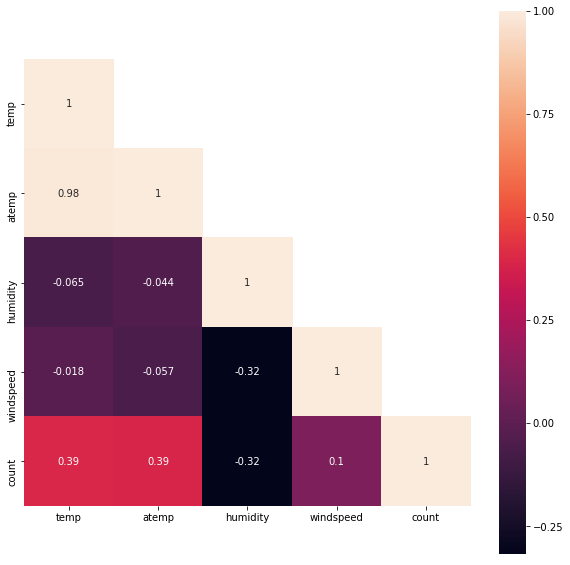

In [11]:
# 使用量与湿度、温度、风速的关系
corrMatt = bike_train[['temp', 'atemp', 'humidity', 
                      'windspeed', 'count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig = plt.figure(figsize=(10,10))
sns.heatmap(corrMatt, mask=mask, square=True, annot=True)

温度和使用量有正相关关系，湿度与使用量有负相关关系，风速和使用量几乎不相关。

d:\python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


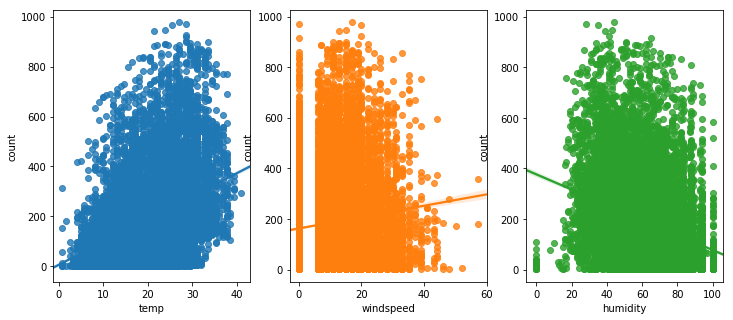

In [12]:
#绘制线性图像
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,5))
sns.regplot(x="temp", y="count", data=bike_train,ax=ax1)
sns.regplot(x="windspeed", y="count", data=bike_train,ax=ax2)
sns.regplot(x="humidity", y="count", data=bike_train,ax=ax3)

由图像可看出，使用量与温度、湿度和风速的关系，相关性有限。

2）单车使用量在时间维度上的分析（月份、季节、时间、星期等相关性）

[[Text(0, 0, 'Weekend'), Text(0, 0, 'Workday')]]

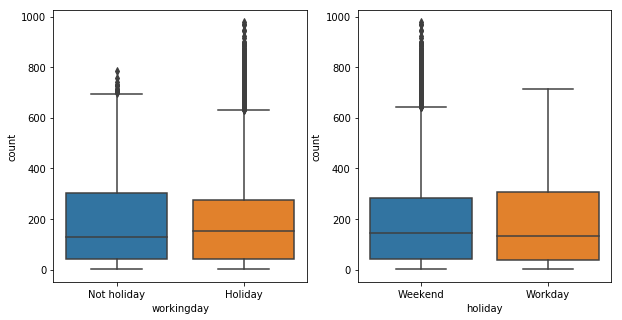

In [13]:
#租车总量和工作日、节假日的关系
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
sns.boxplot(data=bike_train, y='count', x='workingday',ax=ax1)
sns.boxplot(data=bike_train, y='count', x='holiday',ax=ax2)

ax1.set(xticklabels=['Not holiday','Holiday'])
ax2.set(xticklabels=['Weekend','Workday'])

总量来看，节假日和周末/工作日的租车数量基本相同。

[Text(0, 0.5, 'Avearage Count'),
 Text(0.5, 0, 'Hour'),
 Text(0.5, 1.0, 'Average Count By Hour Across weekday')]

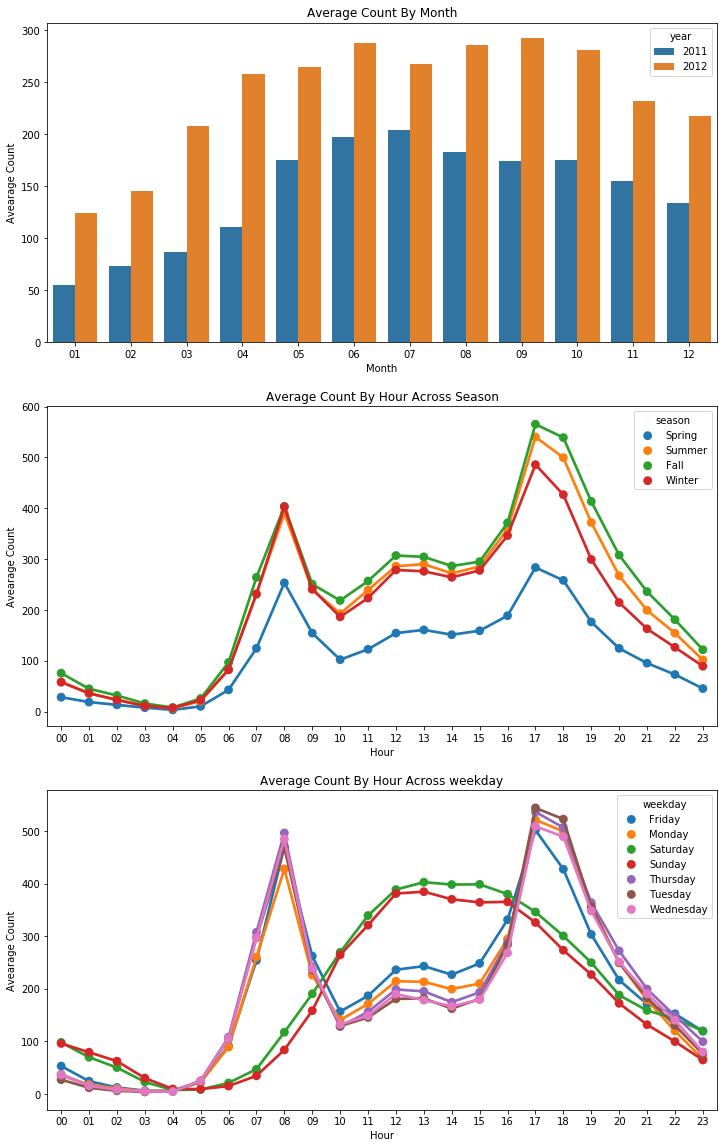

In [14]:
fig,axes = plt.subplots(3,1, figsize=(12,20))
#租车辆按月份、年份统计
month_Aggregated = pd.DataFrame(bike_train.groupby(['year','month'])['count'].mean()).reset_index() 
sns.barplot(data=month_Aggregated,x="month",y="count",hue='year',ax=axes[0])
axes[0].set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

#每日租车辆按季节统计
hour_Aggregated1 = pd.DataFrame(bike_train.groupby(['hour','season'])['count'].mean()).reset_index()
sns.pointplot(data=hour_Aggregated1,x='hour',y='count',hue='season',hue_order=['Spring','Summer','Fall','Winter'],join=True, ax=axes[1])
axes[1].set(xlabel='Hour', ylabel='Avearage Count',title="Average Count By Hour Across Season")

#日租车辆按周统计
hour_Aggregated2 = pd.DataFrame(bike_train.groupby(['hour','weekday'])['count'].mean()).reset_index()
sns.pointplot(data=hour_Aggregated2,x='hour',y='count',hue='weekday',join=True,ax=axes[2])
axes[2].set(xlabel='Hour', ylabel='Avearage Count',title="Average Count By Hour Across weekday")

图1可以看出2012年共享单车的使用量高于2011年，消费人群增加了1.5~2倍。两年内租车量随月份变化的趋势相同，6、7、8月有明显的高需求。

图2可以看出租车时间高峰为上午7-8点，下午5-6点，符合上下班通勤的时间范围。季节上看，春天的租车辆明显少于其它三个季节。

图3可以看出工作日租车辆主要为上下班时间，周末租车辆主要集中在10am-4pm之间。

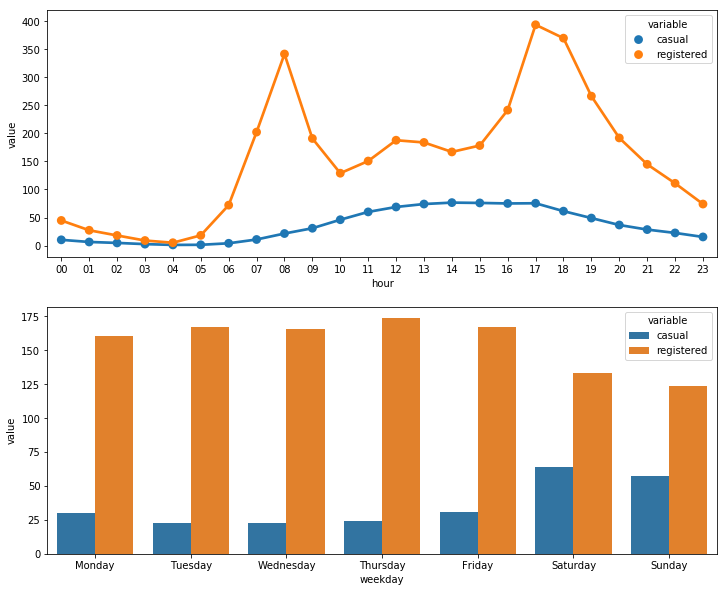

In [15]:
# 3）单车使用量与注册用户/非注册用户的相关性
fig,axes=plt.subplots(2,1,figsize=(12,10))
hour_Transform=pd.melt(bike_train[['hour','casual','registered','weekday']],id_vars=['hour','weekday'],value_vars=['casual','registered'])
hour_Aggregated3=pd.DataFrame(hour_Transform.groupby(['hour','variable'])['value'].mean()).reset_index()
sns.pointplot(data=hour_Aggregated3,x='hour',y='value',hue='variable',hue_order=['casual','registered'],join=True,ax=axes[0])

weekday_Aggregated=pd.DataFrame(hour_Transform.groupby(['weekday','variable'])['value'].mean()).reset_index()
sns.barplot(data=weekday_Aggregated,x='weekday',y='value',hue='variable',order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],ax=axes[1])

注册人数使用量明显高于非注册人数，
非会员casual主要是周末出行，为了游玩; 会员registered主要是为了周一到周五上班。

### 5. 总结

时间：需求量最大的时间为夏、秋季工作日上、下班时间，其次为周末10am-4pm。需求量最小的时间为每年1-3月，时间集中在半夜/凌晨。
天气：除极端情况外（大风、高温、低温、强降水等），天气对租车量的影响不明显。
用户类型：注册用户和普通用户行为特征明显，前者主要为工作日通勤使用，后者为节假日出游。